<img src="images/logo.png">

# Revisiting the 'Titanic Survivors' - ODSC 2017, Boston, MA

At the Open Data Science Conference in Boston held on May 3rd 2017, we presented an introductory workshop on Data Science with Python. This involved teaching Python, Libraries needed for Data Science followed by Logistic Regression with Titanic. This was done with the help of our online self-learning platform : http://refactored.ai

You can still sign up, revisit the workshop and provide feedback on our platform.

Here we are presenting the example problem with more detail as we could only cover as much in the 4 hours duration. 

## Titanic Survivors Problem

Kaggle posted a famous dataset from Titanic. It was about the survivors amongst the people aboard. Here is the description from Kaggle:

### Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

source: https://www.kaggle.com/c/titanic

#### Loading the Data

* The data has been split into train_data, test_data and can be loaded from kaggle with read_csv command:

In [115]:
# Import libraries
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split

import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
sns.set()
sns.set_style("whitegrid")

In [116]:
train_data = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv")

In [117]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Titanic Survivors - Data Selection & Preparation
Prior to fitting a logistic regression model for classifying who would likely survive, we have to examine the dataset with information from EDA as well as using other statistical methods. The logistic regression algorithm is also a supervised learning technique. 

The dataset from training and testing has data that cannot be directly used due to many issues including but not limited to:

Sparse column entries in certain columns such as Cabin.
NaN entries in columns.
Categorical variables with string entries.
Selection of right columns.
Sparsity
Let us examine sparse columns by counting the ratio of NaNs to all the values. describe() function on dataframe provides information about mean, median and the number of values ignoring NaNs only for float/integer columns. 

## Number of Survivors

Let us look at how many people survived the titanic.

/Users/harishkashyap/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


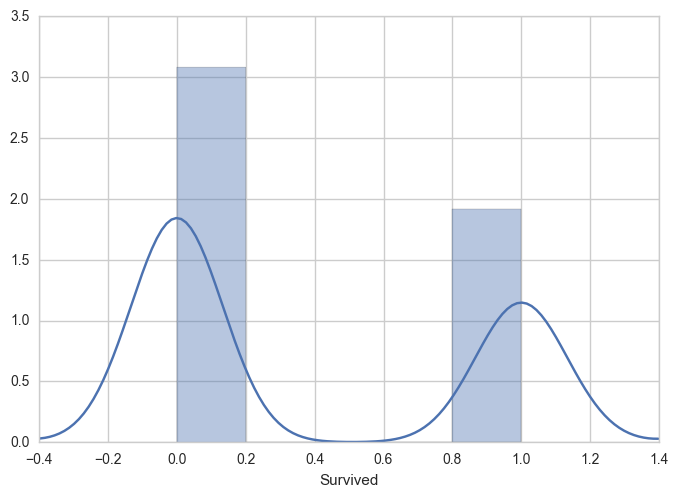

In [118]:
sns.distplot(train_data['Survived'])

From the above distribution, it can be observed that those who survived are approximately 2/3rd in the training set.

## Features Available
### Age
We can see that Age column has 714 entries with missing (891 - 714 = 177) values. This would be 177/891 = 0.19 or approximately 20% of missing values. If this percentage was small, we could choose to ignore those rows for fitting a logistic regression model. There are various methods to fill the missing values. But before we discuss the ways to fix the issue of Age column sparsity, let us examine other columns as well.

### PassengerId, Name, Ticket
We can see that PassengerId, Name and Ticket are all unique to each person and hence will not serve as columns for modeling. Logistic Regression or any supervised or unsupervised learning methods need to understand patterns in the dataset. This is a necessary condition, so that algorithms can make sense of the data available by mathematically recording these patterns. Hence, Ids, Names are usually candidates that aren't useful for modeling. They are needed for identifying the person post recommendation, prediction or classification. They are also going to be useful later for other columns, thereby improving the overall dataset. 

### Cabin
The Cabin column is really sparse with just (148/891 = 0.16) 16% data available. You can use len(train_data.Cabin.unique()) to determine the total length. When data is very sparse, we can ignore it for modeling in the first iteration. Later for improving the fit, this column can be investigated deeper to extract more information.

### Embarked
This data shows the point where passengers Embarked. It has very less sparsity with train_data[train_data.Embarked.notnull()] = 889 which is nearly all the data (891). Hence, it can be useful for modeling.

### Person
This is a column we created ourselves by splitting up age into different bands of Child, Adult, Senior and Unknown. We have to determine how any Unknown people are there so that we can build better models. Since, this variable depends directly on age, if we can fix the sparsity of age, this will be fixed as well.

## Sparsity in the dataset.

Let us analyze the sparsity in the columns of the dataset. This will give us an insight into what feature engineering needs to be done to resolve the sparsity.

In [119]:
raw_features = train_data.columns

for feature in raw_features:
    content_prop = len(train_data[train_data[feature].notnull() == True].index)/len(train_data.index)
    print(feature, content_prop)

PassengerId 1.0
Survived 1.0
Pclass 1.0
Name 1.0
Sex 1.0
Age 0.8013468013468014
SibSp 1.0
Parch 1.0
Ticket 1.0
Fare 1.0
Cabin 0.22895622895622897
Embarked 0.9977553310886644


## Understanding Age of People Aboard

About 20% of age is missing which means we need to find ways to impute it.

/Users/harishkashyap/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


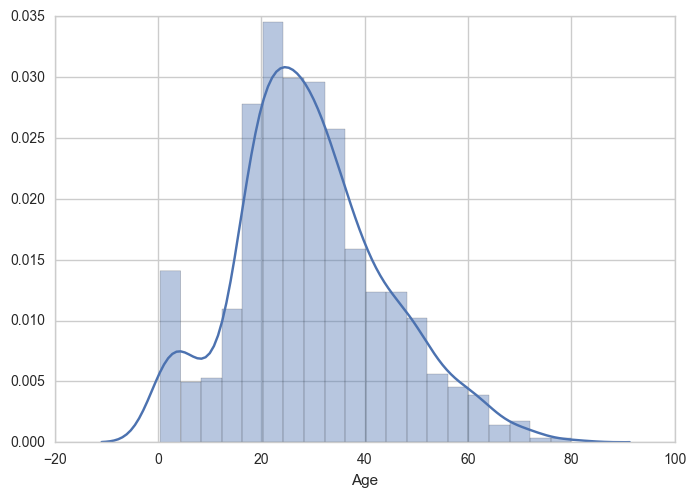

In [120]:
sns.distplot(train_data[train_data['Age'].notnull()].Age)

We do not have any prior information about how the age for child was defined in those years. The above information is helpful as we can categorize the people as child, adults and seniors by looking the peaks.

Let us define functions to categorize the age into these three categories with age of 16 and 48 as the defining separators from the graph.

In [121]:
def person_type(x):
  if x <=16:
    return 'C'
  elif x <= 48:
    return 'A'
  elif x <= 90:
    return 'S'
  else:
    return 'U'

The above function categorizes the continous variable 'Age' into a categorized variable. We can use apply function to transform each entry in the Age column and assign it to Person.

In [122]:
train_data['Person'] = train_data['Age'].apply(person_type)
test_data['Person'] = test_data['Age'].apply(person_type)

We can now look at who is likely to survive depending on the type of Person with a factor plot. A factor plot can consider another factor such as Sex along with the Age. 

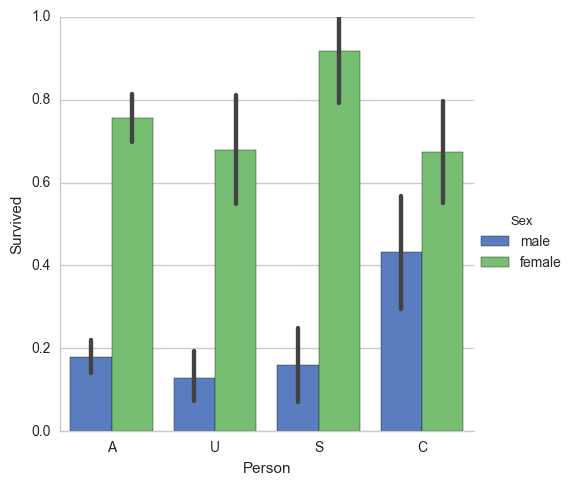

In [123]:
g = sns.factorplot(x="Person", y="Survived", hue="Sex", data=train_data,
                             size=5, kind="bar", palette="muted")

From the above plot you can see that senior women were most likely to survive with highest probability than anyone else. Now we can ignore the Sex type and visualize who was likely to survive.

## Chances of Survival

Let us now look at the class from which people had better chances of survival:

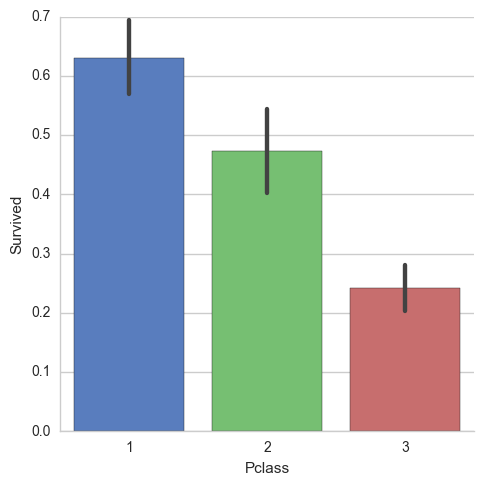

In [124]:
g = sns.factorplot(x="Pclass", y="Survived", data=train_data, size=5,
                   kind="bar", palette="muted")

We can see that 1st class passengers had much better chances of survival. We can also visualize the distribution of Male and Female using a violin plot. This is very useful to measure the mean and variance of passengers as to their likelihood of survival in each class grouped by Male and Female. The distribution graphs are shown on either side of the line for each class.

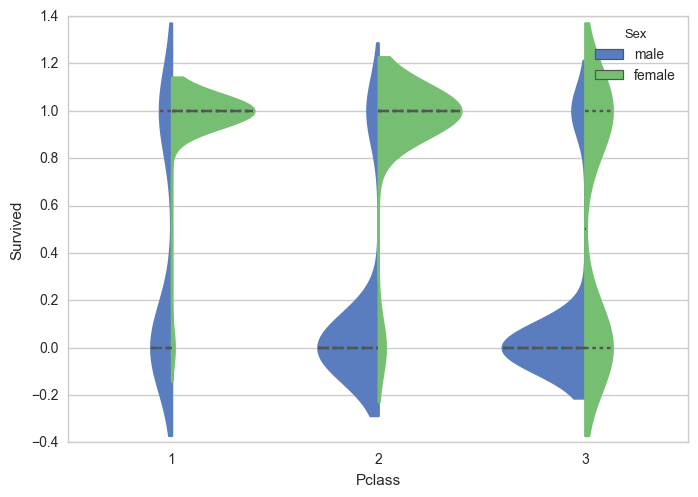

In [125]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="Pclass", y="Survived", hue="Sex", data=train_data, split=True,
               inner="quart", palette="muted")

## Let us look at the distribution of Fare

/Users/harishkashyap/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


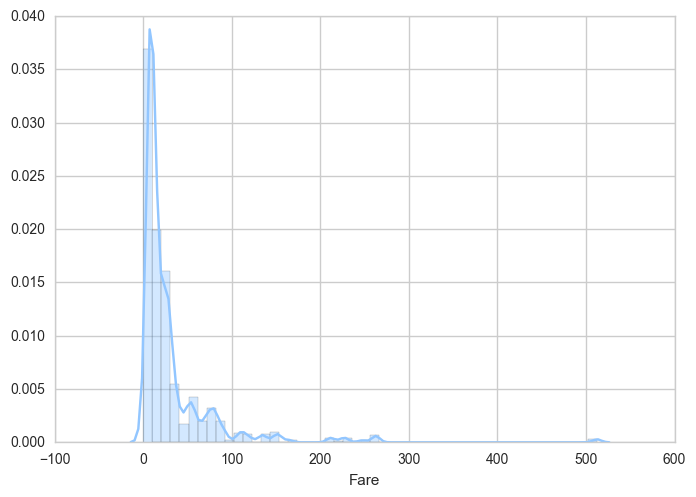

In [140]:
sns.distplot(train_data['Fare'])

In [126]:
train_data.describe()

/Users/harishkashyap/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Statistical Imputations

#### Sex Column
The Sex column has entries male or female, a categorical variable.

Imputation refers to methods of substituting estimates for missing values in the data. This is an important step that can train the model better as more data becomes available post imputations. There are many known methods of imputations. Sometime, by analysis and EDA, we can design custom imputation methods that provide best statistical estimates for the missing value. This reduces sparsity in the dataset. In the Titanic dataset, let us start investigating various methods to impute sparse columns.

### Age Column
To impute the age column, we can use the name information. How many of names with Mr., Mrs., Miss and Master exist and use the mean values for each where the ages are missing. Here are the estimates for each category:

In [127]:
miss_est = train_data[train_data['Name'].str.contains('Miss. ')].Age.mean()
master_est = train_data[train_data['Name'].str.contains('Master. ')].Age.mean()
mrs_est = train_data[train_data['Name'].str.contains('Mrs. ')].Age.mean()
mr_est = train_data[train_data['Name'].str.contains('Mr. ')].Age.mean()

The above estimates can be improved further by considering the Parents column as those names containing Master and Miss would have a subset of children (unmarried referring to Master & Miss). Here is a function that takes all of these rules into consideration:

In [128]:
girl_child_est = train_data[train_data['Name'].str.contains('Miss. ') & (train_data['Parch'] == 1)].Age.mean()
boy_child_est = train_data[train_data['Name'].str.contains('Master. ') & (train_data['Parch'] == 1)].Age.mean()
woman_adult_est = train_data[train_data['Name'].str.contains('Miss. ') & (train_data['Parch'] == 0)].Age.mean()
man_adult_est = train_data[train_data['Name'].str.contains('Master. ') & (train_data['Parch'] == 1)].Age.mean()
woman_married_est = train_data[train_data['Name'].str.contains('Mrs. ')].Age.mean()
man_married_est = train_data[train_data['Name'].str.contains('Mr. ')].Age.mean()

We shall use the above estimates with an imputation function that we will build based on the same rules as above. 

In [129]:
import math
def impute_age(row):
    if math.isnan(row[5]):
        if ((('Miss. ') in row[3]) and (row[7] == 1)):
            return girl_child_est
        elif ((('Master. ') in row[3]) and (row[7] == 1)):
            return boy_child_est
        elif ((('Miss. ') in row[3]) and (row[7] == 0)):
            return woman_adult_est
        elif (('Mrs. ') in row[3]):
            return woman_married_est
        else:
            return man_married_est
    else:
        return row[5]

In [130]:
train_data['Imputed_Age'] = train_data.apply(impute_age, axis=1)
test_data['Imputed_Age'] = test_data.apply(impute_age, axis=1)

## Feature Mapping

Let us start preparing the features for prediction.

In [131]:
train_embarked = pd.get_dummies(train_data['Embarked'])
train_sex = pd.get_dummies(train_data['Sex'])
train_data = train_data.join([train_embarked, train_sex])
test_embarked = pd.get_dummies(test_data['Embarked'])
test_sex = pd.get_dummies(test_data['Sex'])
test_data = test_data.join([test_embarked, test_sex])
train_data['Age_Imputed']=train_data.apply(impute_age, axis=1)
test_data['Age_Imputed']=test_data.apply(impute_age, axis=1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Imputed_Age,C,Q,S,female,male,Age_Imputed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A,22.0,0.0,0.0,1.0,0.0,1.0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,A,38.0,1.0,0.0,0.0,1.0,0.0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,A,26.0,0.0,0.0,1.0,1.0,0.0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,A,35.0,0.0,0.0,1.0,1.0,0.0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,A,35.0,0.0,0.0,1.0,0.0,1.0,35.0


In [132]:
# You dont want this to join twice if you are attempting this lesson multiple times.

try:
    train_embarked = pd.get_dummies(train_data['Embarked'])
    train_sex = pd.get_dummies(train_data['Sex'])
    train_data = train_data.join([train_embarked, train_sex])

    test_embarked = pd.get_dummies(test_data['Embarked']) 
    test_sex = pd.get_dummies(test_data['Sex'])
    test_data = test_data.join([test_embarked, test_sex])
except:
    print("The columns already have the appropriate features.")

The columns already have the appropriate features.


## Logistic Regression using Statsmodels

In [133]:
features = ['Pclass', 'Imputed_Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'female']
log_model = sm.Logit(train_data['Survived'], train_data[features]).fit()
y_pred = log_model.predict(train_data[features])

roc_survival = roc_curve(train_data[['Survived']], y_pred)

Optimization terminated successfully.
         Current function value: 0.450489
         Iterations 6


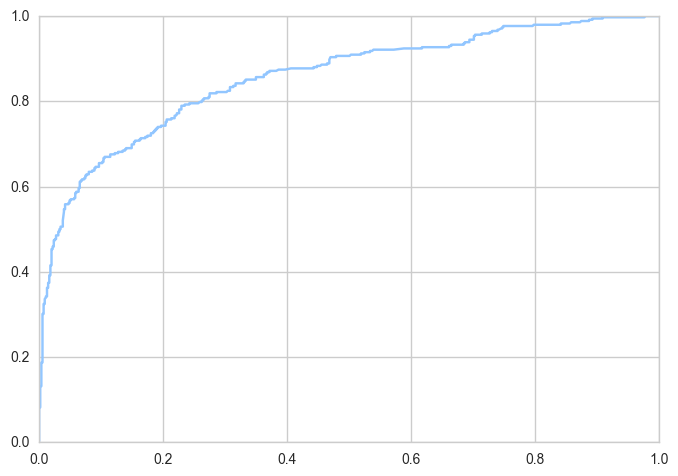

In [134]:
sns.set_style("whitegrid")
sns.plt.plot(roc_survival[0], roc_survival[1])
sns.plt.show()

## Logistic Regression using Scikit-Learn

Here we shall learn how to perform modeling using scikit-learn.

In [135]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Instantiate a logistic regression model as:

In [136]:
log_sci_model = LogisticRegression()

Train the model with 'Fare':

In [137]:
from sklearn import metrics, cross_validation
from sklearn.linear_model import LogisticRegression

# Modify the code below to include all possible features.

features = ['Pclass', 'Imputed_Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'female']
log_sci_model = LogisticRegression()
log_sci_model = log_sci_model.fit(train_data[features], train_data['Survived'])
log_sci_model.score(train_data[features], train_data['Survived'])

0.79685746352413023